In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

from liquidity.features import compute_aggregate_features

from market_impact.fit import fit_scaling_law
from market_impact.util.utils import normalize_imbalances
from market_impact.response_functions import aggregate_impact
from market_impact.util.plotting.constants import EBAY_COLORS
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.plotting.plot import plot_scaling_function, plot_collapsed_scaling_function

In [ ]:
# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

<!--
Copyright 2022 Kenji Harada
-->
# Finitie-size scaling analysis
The statistics of price returns have been purported to exhibit robust scaling dynamics resembling those of systems in critical states  where the maximum increments of asset returns were previously shown to be limited only by a second upper cutoff due to, for example, the finite size of the system. We perform a finite-size scaling analysis  of the signed conditional aggregate impact of an order and characterize the critical exponents of relevant observables such as price returns signs and signed volume imbalances. In this notebook, we introduce a FSS based on the method of Leas-squares, see:

- Patzelt, F. and Bouchaud, J.P., 2018. 

## Finitie-size scaling of non-equilibrium phenomena


Upon introduction of properly scaled variables, the finite-size scaling (FSS) analysis extracts numerical values for critical exponents that describe a given critical phenomenon in a finitie-size system. More formally, the scaling assumption states that if a physical quantity is considered to obey scaling, it can be expressed as 
$$ 
y\left(x, T\right) = T^{\chi} \mathscr{F}\left(xT^{-\varkappa}\right), 
$$
where x is a variable describing a physical system of which size is T, and exponents $\chi$ and $\varkappa$ are critical exponents. $\mathscr{F}(\cdot)$ is a scaling function which too exhibits universality. Then the FSS analysis is an inference of critical parameters so that if we introduce new variables
$$ 
X \equiv xT^{-\kappa}, Y \equiv y /T^{\chi} =  yT^\chi 
$$
then the FSS law rewrites as 
$$
Y = \mathscr{F}(x)
$$
such that the data points collapse onto a single scaling function. 

## Infering the scaling function from data 
Because we may not know the form $\mathscr{F}$ $\textit{a prior}$ on grounds of theory, the statistical inference problem is acute and one has to assume both values of critical exponents as well as the form of the scaling function itself. Although $\mathscr{F}(𝑥)$ can in principal function of virtually any form, Patzelt and Bouchaud (2018) and Farmer, Gerig and Lillo (2008) find it is well appoximated by a sigmoidal:
\begin{align*}
\mathscr{F}(x) = \frac{x}{\left(1 + | x |^\alpha \right)^{\beta / \alpha}},
\end{align*}
which describes empirical observations for signed aggregate impact, where $\alpha$ and $\beta$ regulate the shape (steepness and symmetry) of $\mathscr{F}$.

## Empirical scaling of price returns
We are particualrly interested in the scaling laws governing the form of conditional aggregate price returns 
\begin{align*}
R\left(\Delta \mathcal{E}, T\right) \cong R_T \cdot \mathscr{F}\left(\frac{\Delta \mathcal{E}}{\mathcal{E}_T}\right).
\end{align*}
where and $R_T $ and $\mathcal{E}_T$ are unknown scaling factors that do not depend on 𝑥, but instead on the system size T. In fact, without imposing any assumptions, empiricism suggests a scaling law of the form
\begin{align*}
\mathcal{E}_T  \thicksim \mathcal{E}_DT^\varkappa, \\
    R_T \thicksim \mathcal{R}(1)T^\chi, 
\end{align*}
which yields the following scaling law
\begin{align*}
R \left(\Delta \mathcal{E}, T \right) = \mathcal{R}(1)T^\chi \cdot \mathscr{F}\left(\frac{\Delta \mathcal{E}}{\mathcal{E}_DT^\varkappa}\right),
\end{align*}
for aggregate price returns, where $\mathcal{R}(1)$, $\mathcal{E}_D$ represent constants of unit dimension that define a characteristic length scale.

In [3]:
# Constants 
DATA_RANGE = list(range(10, 151))
BINNING_FREQUENCIES = [10, 20, 50, 100, 150]

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
aapl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [5]:
aapl_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.01,0.01,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.00,0.00,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10


### Aggregate features 
We first coarse-grain the data into different binning frequencies $T$ that represent different system sizes (in event time) by marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [6]:
# Compute aggregate features 
aggregate_features = compute_aggregate_features(aapl_raw_df, DATA_RANGE)
display(aggregate_features)

,event_timestamp,midprice,summed_returns,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,midprice_from_returns,T
1,2017-01-03 10:30:10.822214435,115.705,0.020,1,130,True,0.004271,6170,1398089,258,2,7,7.283424,1045.040418,115.705,10
2,2017-01-03 10:30:19.782301269,115.725,0.010,1,396,False,0.004271,6170,1398089,396,0,7,7.283424,1045.040418,115.725,10
3,2017-01-03 10:30:28.753651077,115.735,0.020,-1,-100,False,0.004271,6170,1398089,709,4,4,6.032068,762.184840,115.735,10
4,2017-01-03 10:30:34.132511059,115.755,-0.020,1,174,True,0.004271,6170,1398089,2855,2,5,7.283424,1045.040418,115.755,10
5,2017-01-03 10:30:54.620450561,115.735,-0.010,-1,-300,False,0.004271,6170,1398089,900,2,7,6.032068,762.184840,115.735,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17554,2017-12-29 14:16:14.177009449,170.045,-0.070,-1,-236,False,0.030568,6735,1452499,-11440,-16,95,3.890007,725.867637,170.045,150
17555,2017-12-29 14:29:17.956795892,169.975,0.010,1,616,True,0.030568,6735,1452499,-10101,-18,69,3.711482,773.098946,169.975,150
17556,2017-12-29 14:40:18.608198426,169.985,-0.035,-1,-825,True,0.030568,6735,1452499,-8553,-16,72,3.890007,725.867637,169.985,150
17557,2017-12-29 14:49:24.287968532,169.950,0.045,1,200,True,0.030568,6735,1452499,-2771,2,81,3.711482,773.098946,169.950,150


### Aggregate imapct
From aggegate features, we compute aggregate impact of market orders MO. All impact data are automatically rescaled  rescaled each day by the corresponding values of $R(1)$ and the daily number $\mathcal{E}_D$ in preprartion for FSS analysis.

In [69]:
# Compute data for susceptibility
imbalance_column = "volume_imbalance"
aggregate_impact_data = aggregate_impact(aggregate_features, conditional_variable=imbalance_column)
display(aggregate_impact_data)

,event_timestamp,midprice,summed_returns,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_num_at_best,average_vol_at_best,midprice_from_returns,T,price_change,R
1,2017-01-03 10:30:10.822214435,115.705,0.020,1,130,True,0.004271,6170,1398089,0.000185,2,7,7.283424,1045.040418,115.705,10,0.020,4.683112
2,2017-01-03 10:30:19.782301269,115.725,0.010,1,396,False,0.004271,6170,1398089,0.000283,0,7,7.283424,1045.040418,115.725,10,0.010,2.341556
3,2017-01-03 10:30:28.753651077,115.735,0.020,-1,-100,False,0.004271,6170,1398089,0.000507,4,4,6.032068,762.184840,115.735,10,0.020,4.683112
4,2017-01-03 10:30:34.132511059,115.755,-0.020,1,174,True,0.004271,6170,1398089,0.002042,2,5,7.283424,1045.040418,115.755,10,-0.020,-4.683112
5,2017-01-03 10:30:54.620450561,115.735,-0.010,-1,-300,False,0.004271,6170,1398089,0.000644,2,7,6.032068,762.184840,115.735,10,-0.010,-2.341556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17554,2017-12-29 14:16:14.177009449,170.045,-0.070,-1,-236,False,0.030568,6735,1452499,-0.007876,-16,95,3.890007,725.867637,170.045,150,-0.070,-2.289982
17555,2017-12-29 14:29:17.956795892,169.975,0.010,1,616,True,0.030568,6735,1452499,-0.006954,-18,69,3.711482,773.098946,169.975,150,0.010,0.327140
17556,2017-12-29 14:40:18.608198426,169.985,-0.035,-1,-825,True,0.030568,6735,1452499,-0.005888,-16,72,3.890007,725.867637,169.985,150,-0.035,-1.144991
17557,2017-12-29 14:49:24.287968532,169.950,0.045,1,200,True,0.030568,6735,1452499,-0.001908,2,81,3.711482,773.098946,169.950,150,0.045,1.472131


### Determine shape parameters  
Determine the shape parameters $\alpha$ and $\beta$ of scaling function $\mathscr{F}(\cdot)$ by fitting the</b>
scaling function for $\textit{all}$ T.

In [70]:
alpha, beta = find_shape_parameters(aggregate_impact_data, imbalance_column=imbalance_column)
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.5061672867408239
beta: 2.916826262667706


### Map-out scale factors
Once $\mathscr{F}(\cdot)$ is fixed, one can map out the scale factors as a function of T (i.e., for each system size T), which are well very approximated by power-laws of T.

[]

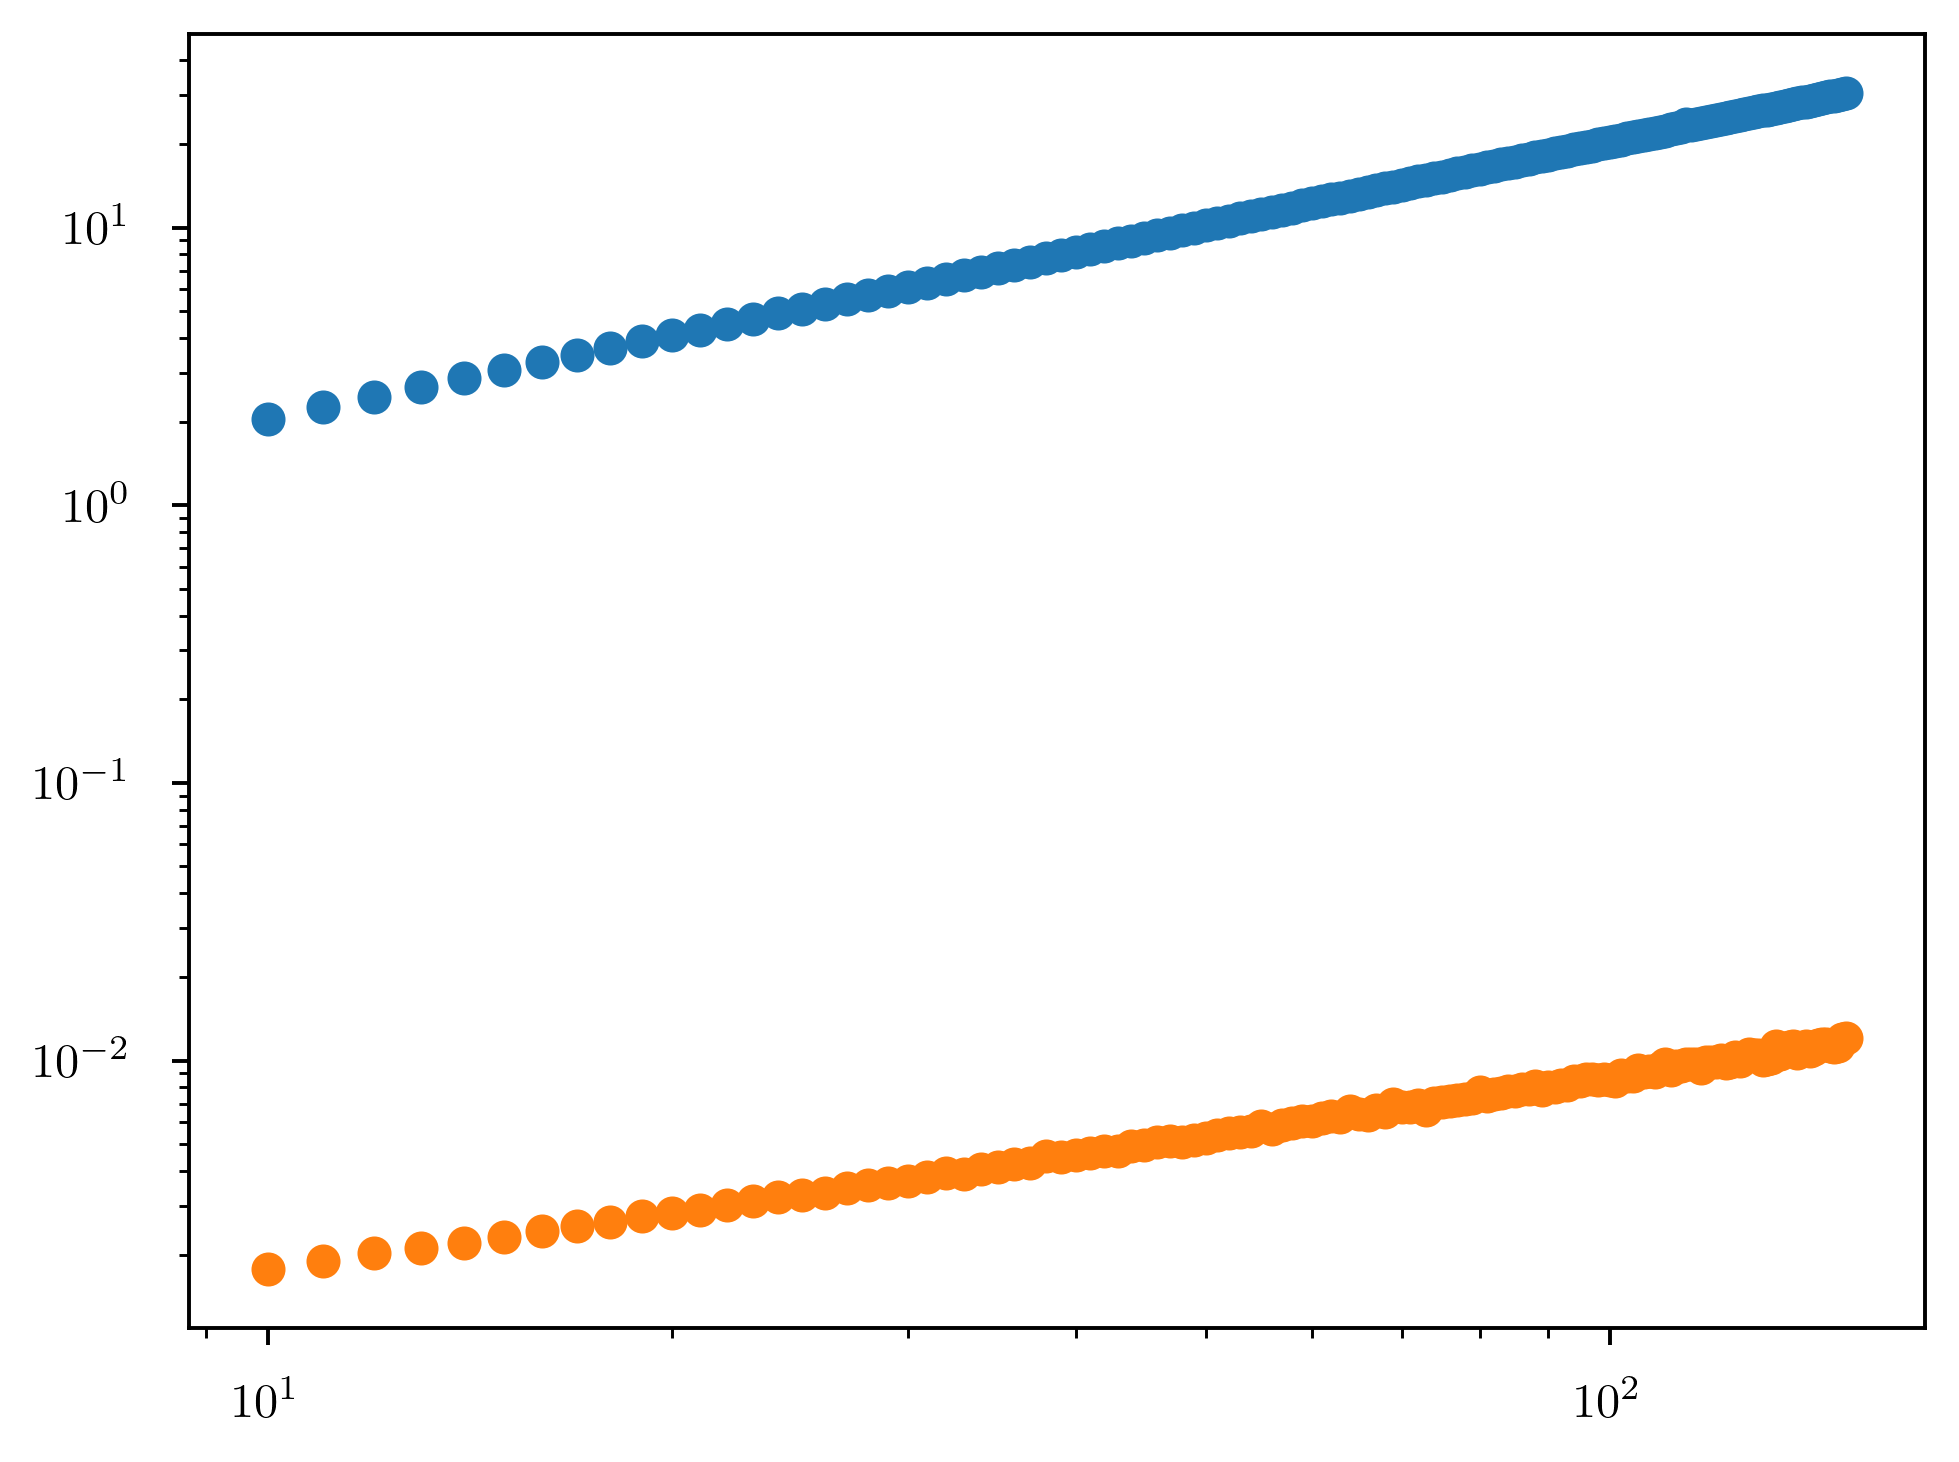

In [71]:
RT_series, VT_series, RT_fit_object, VT_fit_object = find_scale_factors(aggregate_impact_data, alpha=alpha, beta=beta, imbalance_column=imbalance_column)
# Plot scale factors RN and QN
plt.scatter(RT_series['x_values'], RT_series['y_values'])
plt.scatter(VT_series['x_values'], VT_series['y_values'])
plt.loglog()

In [72]:
RT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.206039516034897
alpha = 0.9971899708592429

Goodness of fit to data;
D = 0.007633587786259542
bic = -802.7026471232248
mape = 0.043386807771873113
Adjusted R-squared = 0.9999660874669979




In [73]:
VT_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 20.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.00033347842923443717
alpha = 0.7087129845654996

Goodness of fit to data;
D = 0.022900763358778626
bic = -2269.479603650453
mape = 1.3119572118996699
Adjusted R-squared = 0.995703368395897




### Determine rescaling exponents
In order to determine the rescaling exponents $\chi$ and $\varkappa$, the shape of the scaling form is fitted for each T keeping the same/constant values of $\alpha$ and $\beta$,</b> which are well approximated by the power law.

In [49]:
chi = RT_fit_object.powerlaw.params.alpha
kappa = VT_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9971899708592429
0.7087129845654996


## Do FSS by method of Least-squares
We can now use the found empirical scaling law to perform the FSS.

In [59]:
# Prepare original data for fitting
t_values = aggregate_impact_data['T'].values
imbalance_values = aggregate_impact_data[imbalance_column].values
r_values = aggregate_impact_data['R'].values

# Fit data for all Ts
params = fit_scaling_law(t_values, imbalance_values, r_values, reflect_y=False)

In [60]:
chi, kappa, alpha, beta, CONST = params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')

chi: 0.49166988226670133
kappa: 0.7895232980719078
alpha: 0.41594981265212827
beta: 29.487581559543894


We plot the scaling for different binning_frequencies, where aggregate impact after a trade "appears" to grow linear in volume imbalance with increasing $T$.

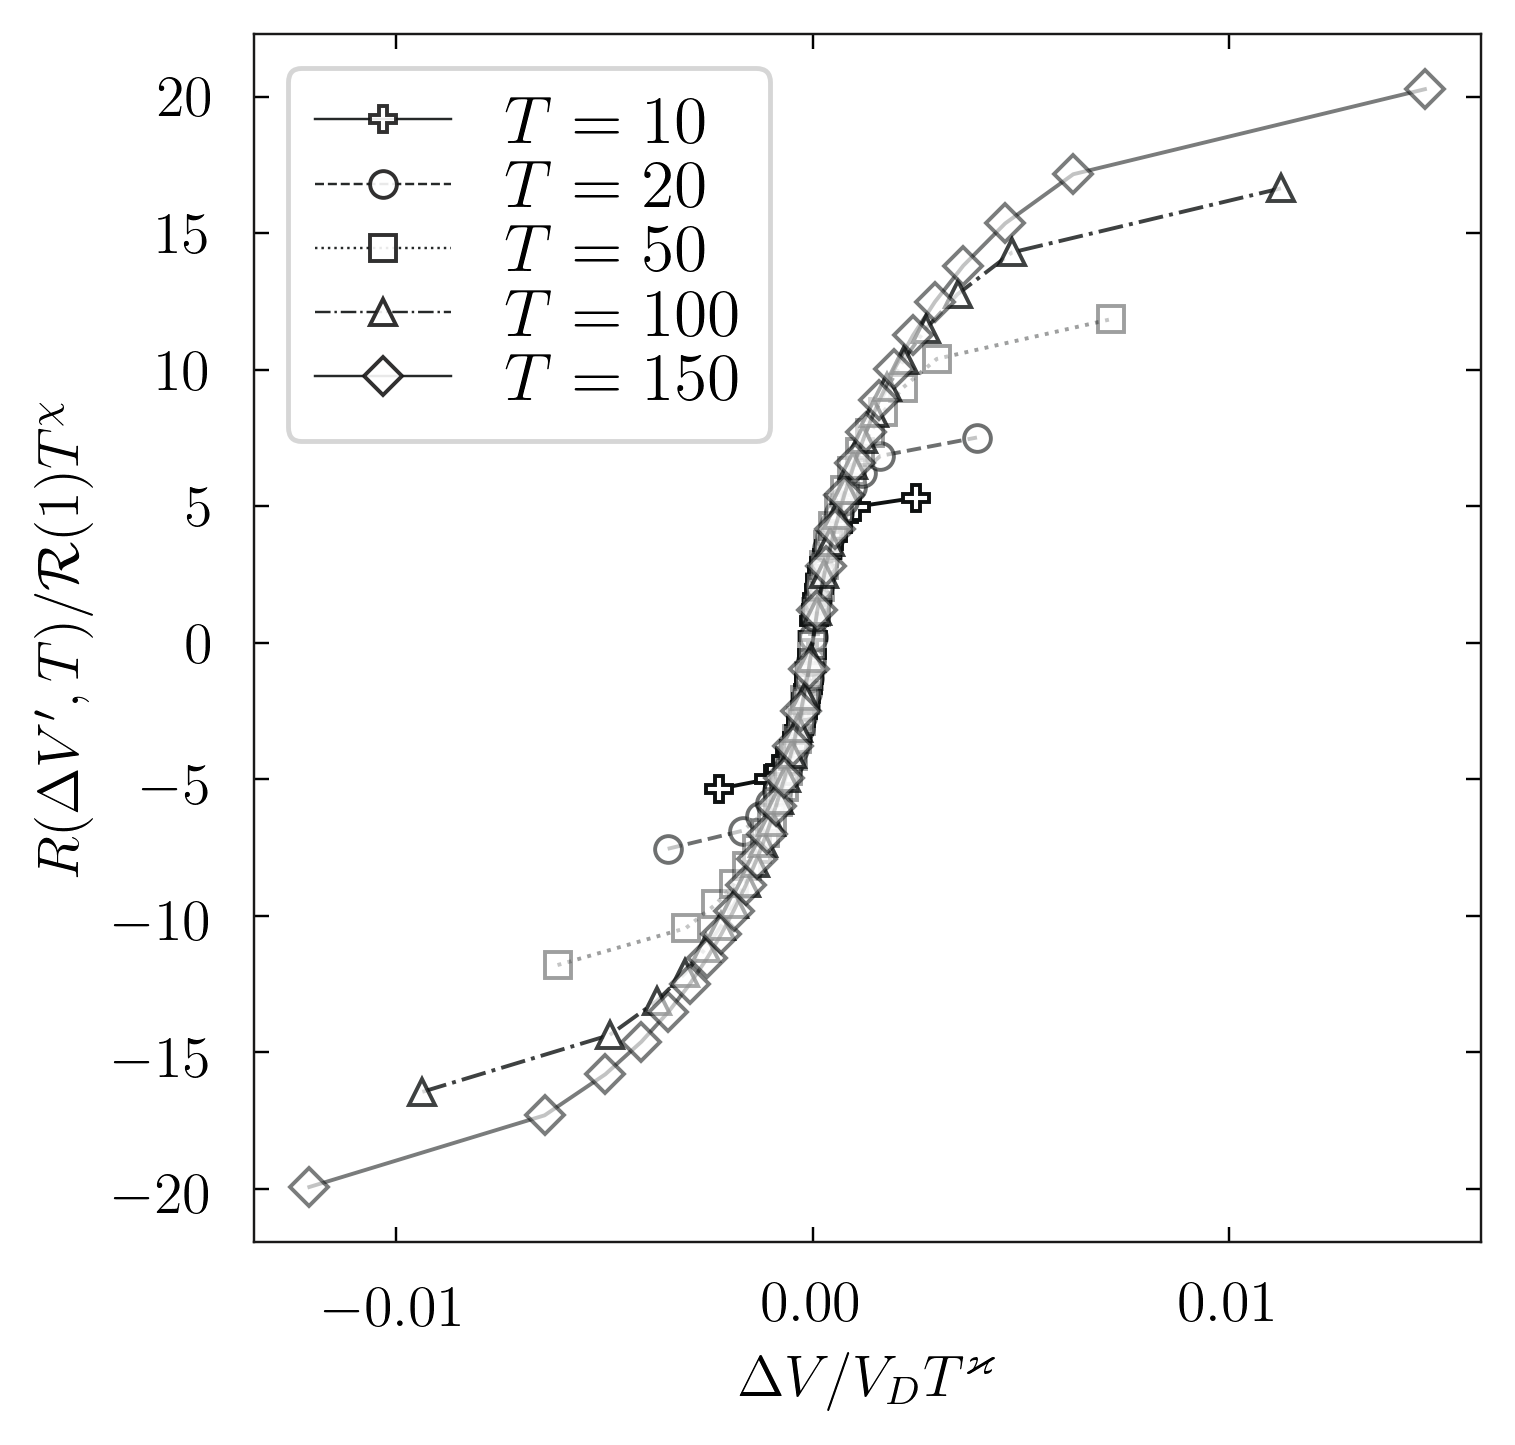

In [61]:
plot_scaling_function(aggregate_impact_data, scaling_params=params,
                  line_color=EBAY_COLORS.dark_color,
                  markers_color="white", 
                  imbalance_column=imbalance_column)

### Transform data
To do the fss by method of least-squares, we use optimized critical paramters to rescale the scaling function onto a single master curve by initially fitting the scaling law to all $T$.

In [62]:
# Transform original data using found rescaling exponents chi 𝛘 and kapp ϰ
rescaled_data = transform(aggregate_impact_data, rescaling_params=params, imbalance_column=imbalance_column)

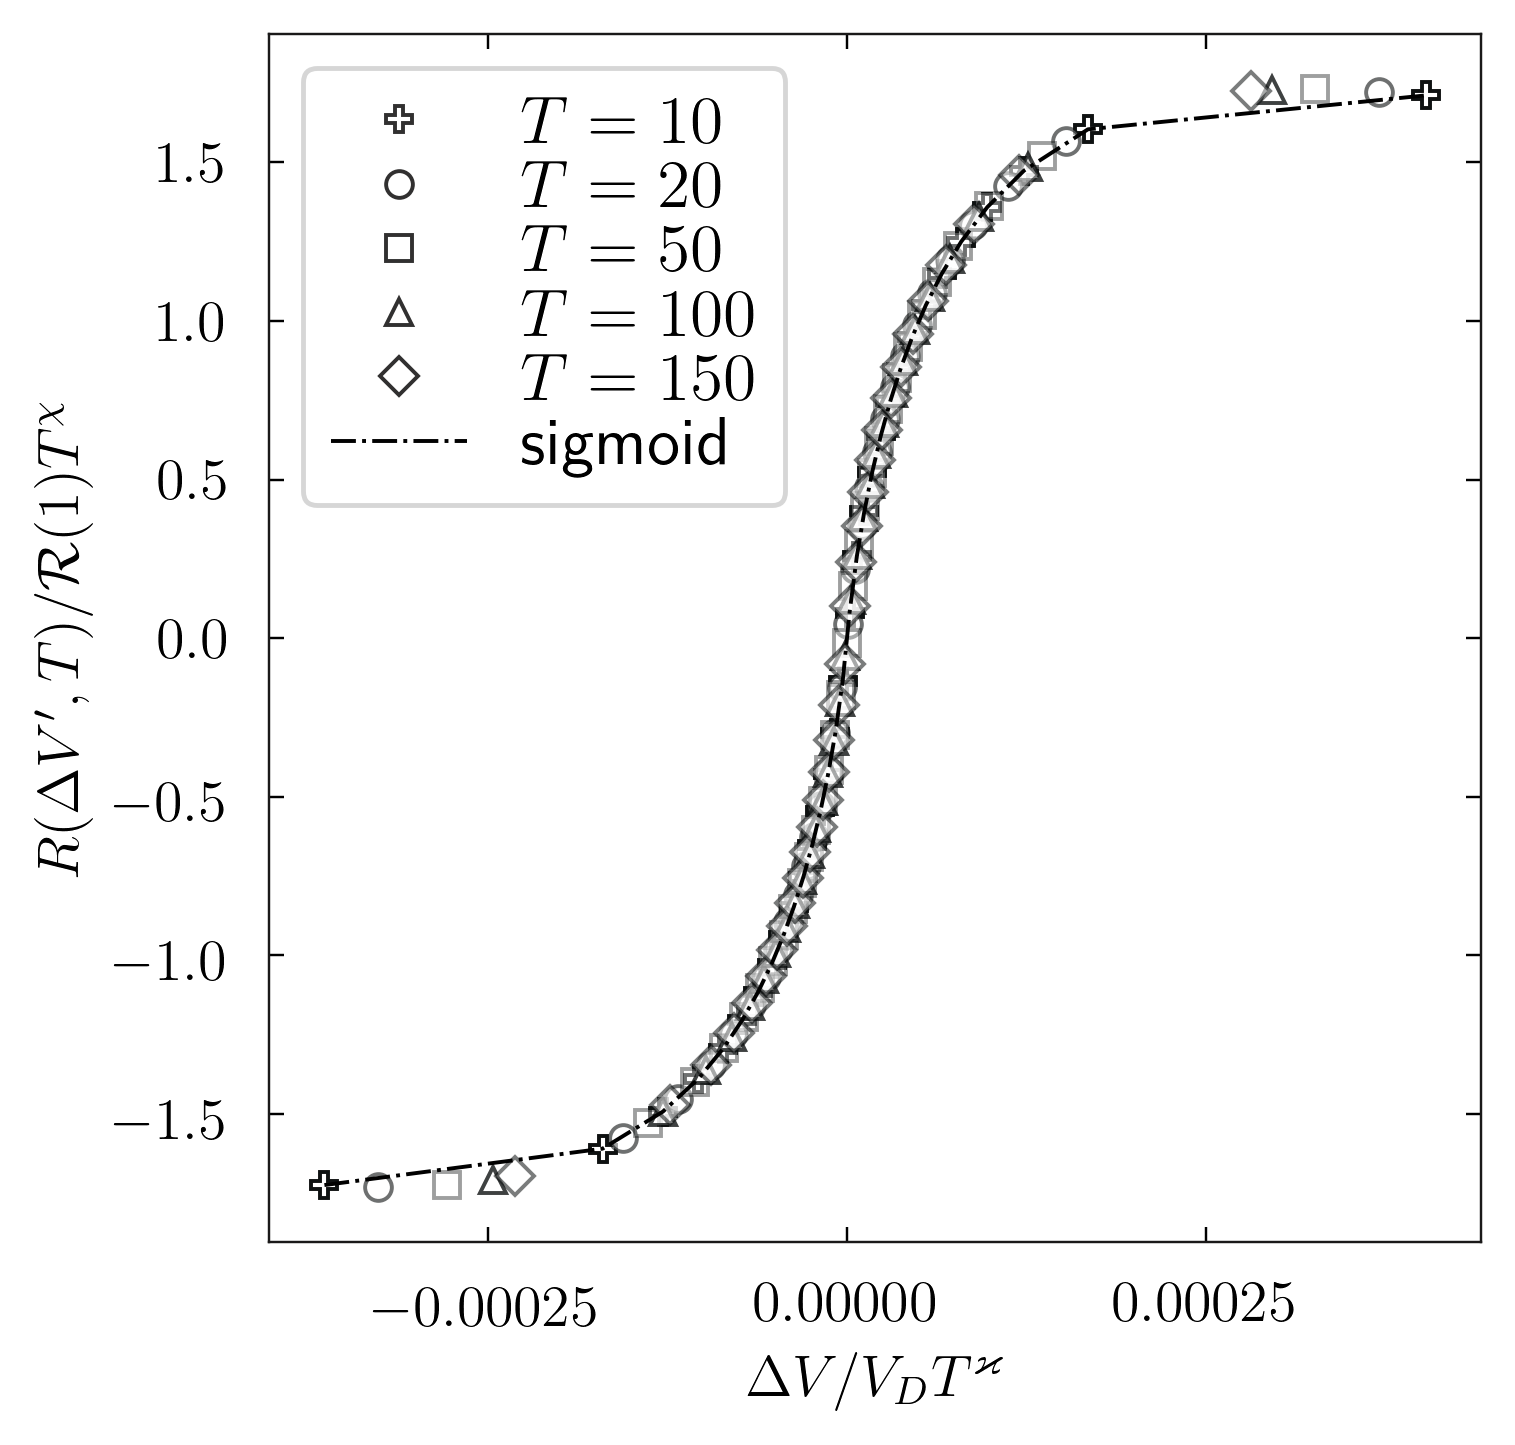

In [63]:
plot_collapsed_scaling_function(rescaled_data,  scaling_params=params,
                  line_color=EBAY_COLORS.dark_color,
                  markers_color="white", imbalance_column=imbalance_column, master_curve=f"sigmoid")